In [2]:
import sys
import torch
import ot

import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./lib")
from distributions import sampleWrappedNormal
from utils_hyperbolic import *
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare
from sw import sliced_wasserstein

/usr/local/lib/python3.10/dist-packages/ot/backend.py:1368: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  jax.device_put(jnp.array(1, dtype=jnp.float64), d)
/usr/local/lib/python3.10/dist-packages/ot/backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
mu0 = torch.tensor([1,0,0], dtype=torch.float64, device=device)
Sigma0 = torch.eye(2, dtype=torch.float, device=device)

In [5]:
x0 = torch.from_numpy(np.array([1,0,0])).to(device)
v = torch.from_numpy(np.array([0,1,1])/np.sqrt(2)).to(device)

## Lorentz Model

In [6]:
n_try = 20
n = 500

t = torch.linspace(-10, 10, 201, dtype=torch.float64).to(device)
# mus = torch.cat([torch.sqrt(1+ys[:,None]**2), ys[:,None], torch.zeros((201,1), device=device)], axis=-1)
mus = torch.cosh(t)[:,None] * x0 + torch.sinh(t)[:,None] * v/torch.linalg.norm(v)

In [7]:
-mus[:,0]**2 + mus[:,1]**2 + mus[:,2]**2

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.00

### HSW

In [8]:
L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)
#         hsw = hyper_sliced_wasserstein(x0, x1, 1000, device, p=2)
        hsw = hyper_sliced_wasserstein(x0, x1, 1000, device, p=2)
        L[i,k] = hsw.item()

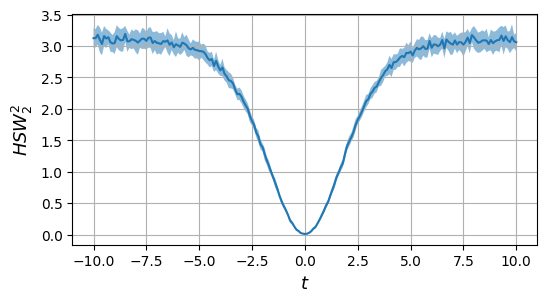

In [9]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$HSW_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./HSW_WND.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [10]:
np.savetxt("./HSW_WND.csv", L, delimiter=",")

### HHSW

In [11]:
L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)
        hsw = horo_hyper_sliced_wasserstein_lorentz(x0, x1, 1000, device, p=2)
        L[i,k] = hsw.item()

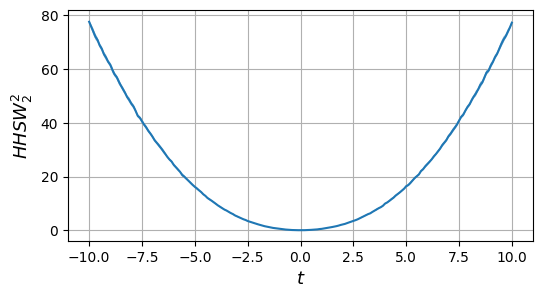

In [12]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$HHSW_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./HHSW_WND_lorentz.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [13]:
np.savetxt("./HHSW_WND_Lorentz.csv", L, delimiter=",")

### SW

In [14]:
L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)
        hsw = sliced_wasserstein(x0, x1, 1000, device, p=2)
        L[i,k] = hsw.item()

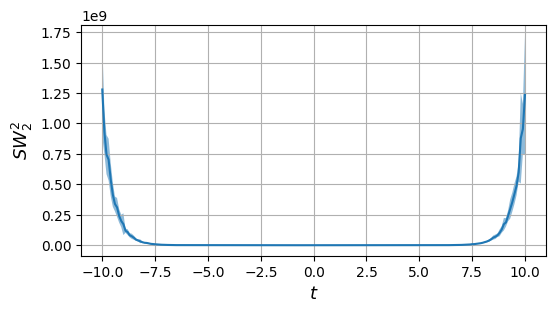

In [15]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$SW_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./SW_WND_lorentz.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [16]:
np.savetxt("./SW_WND_Lorentz.csv", L, delimiter=",")

### W

In [17]:
n = 200

L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = sampleWrappedNormal(mu, Sigma0, n)
        x1 = sampleWrappedNormal(mu0, Sigma0, n)

        a = torch.ones((n,), device=device)/n
        b = torch.ones((n,), device=device)/n
        M = torch.arccosh(torch.clamp(-minkowski_ip2(x0, x1), min=1+1e-5))**2
        w = ot.emd2(a, b, M)

        L[i,k] = w.item()

# print(np.mean(L, axis=-1), np.std(L, axis=-1))

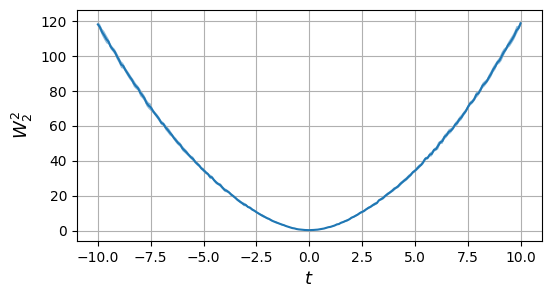

In [18]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$W_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./W_WND.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [19]:
np.savetxt("./W_WND.csv", L, delimiter=",")

## Poincaré Ball

### HHSW

In [20]:
from hhsw import horo_hyper_sliced_wasserstein_lorentz, horo_hyper_sliced_wasserstein_poincare

In [21]:
L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = lorentz_to_poincare(sampleWrappedNormal(mu, Sigma0, n))
        x1 = lorentz_to_poincare(sampleWrappedNormal(mu0, Sigma0, n))
        hsw = horo_hyper_sliced_wasserstein_poincare(x0, x1, 1000, device, p=2)
        L[i,k] = hsw.item()

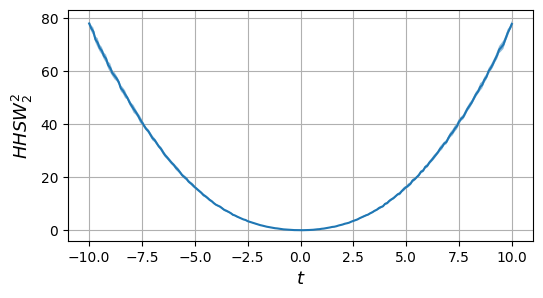

In [22]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$HHSW_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./HHSW_WND_poincare.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [23]:
np.savetxt("./HHSW_WND_poincare.csv", L, delimiter=",")

### SW

In [24]:
L = np.zeros((len(mus), n_try))
for i, mu in enumerate(mus):
    for k in range(n_try):
        x0 = lorentz_to_poincare(sampleWrappedNormal(mu, Sigma0, n))
        x1 = lorentz_to_poincare(sampleWrappedNormal(mu0, Sigma0, n))
        hsw = sliced_wasserstein(x0, x1, 1000, device, p=2)
        L[i,k] = hsw.item()

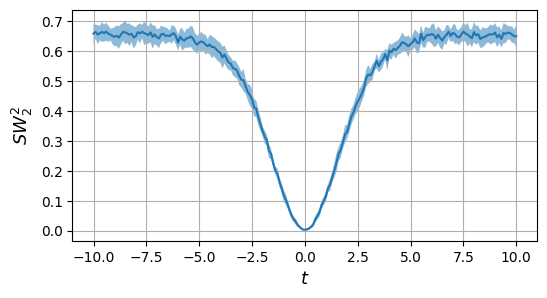

In [25]:
fig = plt.figure(figsize=(6,3))
L_mean = np.mean(L, axis=-1)
L_std = np.std(L, axis=-1)
plt.plot(t.detach().cpu(), L_mean)
plt.fill_between(t.detach().cpu(), L_mean-L_std, L_mean+L_std, alpha=0.5)
plt.xlabel(r"$t$", fontsize=13)
plt.ylabel(r"$SW_2^2$", fontsize=13)
plt.grid(True)
plt.savefig("./SW_WND_poincare.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
np.savetxt("./SW_WND_poincare.csv", L, delimiter=",")